# **Introduction** 

Here we show a simple notebook for a forecasting analysis of COVID19 cases or fatalities based on a Bayesian Ridge model. 
The idea is to use this simple classification model on a dataset which will be reorganised to re-cast the initial task (time series analysis) into a classification task which can be addressed with the Bayesian Ridge model. This approach is inspired by this post https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/.  
The method and model have two main limitations
1. The model is not aware of the intrinsic data nature: the cumulative cases/fatalities vs time can only grow, the model is not constrained to reproduce naturally this behaviour 
2. The model is based on the available data; all the data is equally important in the model fitting process. This is clearly a limitation; let's for example consider the confirmed cases vs time. They will grow much faster at the beginning of the pandemic while, later on, the grow rate will flatten due to restrictive measures taken by individual countries. As result the model will have a tendency to over-predict the amount of cumulative confirmed cases vs time.  

The full code used to prepare this notebook is here https://github.com/nicola-orlando/covid-19-time-series. 

# **Analysis** 

We begin by importing the relevant python modules that we will need for the analysis 

In [ ]:
# Importing relevant python modules

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

#from collections import Counter
import math

import pandas as pd

from sklearn import linear_model 
from sklearn.linear_model import BayesianRidge, LinearRegression

import pickle

We focus on a given feature we want to predict, say the cumulative cases vs time (ConfirmedCases), this can be generalised without any technical challenge. 

In [ ]:
feature_to_analyse='ConfirmedCases'

We are now ready to load the data and look at it. 

In [ ]:
print("Load the datasets ...")
file_path_train="/kaggle/input/covid19-global-forecasting-week-4/train.csv"
file_path_test="/kaggle/input/covid19-global-forecasting-week-4/test.csv"
df_input_train=pd.read_csv(file_path_train)
df_input_test=pd.read_csv(file_path_test)
print("Looking at the raw input train data ...")
print(df_input_train.head())
print("Looking at the raw input test data ...")
print(df_input_test.head())

# Simple replacement(s)
df_input_train = df_input_train.replace({'Country_Region': {'"Korea, South"': 'Korea, South'}}) 
df_input_test = df_input_test.replace({'Country_Region': {'"Korea, South"': 'Korea, South'}}) 

### **Comments on the input data** 

We can easily spot a few properties of the dataset
* It includes days without confirmed cases and fatalities; these entries are not useful to make a prediction of their time evolution. They will be dropped in the following 
* Some countries will be split by Province. While this makes sense as different provinces will have different evolution of the pandemic (maybe due to non uniform containment policy), the discussion in this notebook doesn't address this possibility, all provinces are all merged based on the country. But the extension to split any prediction by province is technically trivial. 

Let's give a look at a specific country

In [ ]:
# Get list of countries to analyse
def list_of_countries(dataframe,test_run=True,print_verbose=False):
    if print_verbose:
        print('\n----> Obtaining list of countries')
    countries=[]
    if test_run:
            countries.append('Italy')
    else: 
        countries=dataframe.Country_Region.unique()
    return countries 

# Get the countries we want to use
countries=list_of_countries(df_input_train)

You can see that in this case we pickup Italy as test ground, to run this notebook over all countries just need to replace 'test_run=True' with 'test_run=False' and loop over the output of *list_of_countries*. 

Now we do some basic operations to prepare the data in a more suitable format. This is achieved with a few functions listed below. 

In [ ]:
# Used to merge different regions of some contries (Canada, France, ..)
def group_and_sum(dataframe,first_feature,second_feature,manipulated_data_first,manipulated_data_second,title_first,title_second): 
    grouped_data = dataframe.groupby([first_feature,second_feature])[manipulated_data_first,manipulated_data_second].sum().reset_index()
    return grouped_data

# Cleanup, rearrange and select a given country in the dataset
def prepare_dataset_for_training(dataframe,country,feature_to_predict_first,feature_to_predict_second,feature_to_predict_name_first,feature_to_predict_name_second,print_verbose=False):
    if print_verbose:
        print('\n----> Minimal manipulation on training data')
    dataframe=dataframe[dataframe.Country_Region == country]    
    # Remove entries with no data
    dataframe=dataframe[feature_to_predict_first != 0]    
    dataframe=group_and_sum(dataframe,'Date','Country_Region',feature_to_predict_name_first,feature_to_predict_name_second,feature_to_predict_name_first,feature_to_predict_name_second) 
    return dataframe 

# Pickup the relevant country only
def prepare_dataset_for_testing(dataframe,country,print_verbose=False):
    if print_verbose:
        print('\n----> Pickup the country from the testing data corresponding to the country selected in the training data')
    dataframe=dataframe[dataframe.Country_Region == country]    
    return dataframe 

### **Description of the fuctions**

Here's is what each one of them does 
* *group_and_sum*: groups the data based on a given country and sums over the provinces (if the Province field is non null). 
* *prepare_dataset_for_training*: prepares the dataset for the training, as mentioned earlier removes data entries with no ConfirmedCases, and match the country to the actual country of interest (Italy in this specific example).
* *prepare_dataset_for_testing*: just makes sure that we apply at testing time a model which is trained with data from the same country as in the testing dataset. 

Let's now start to prepare the data.

In [ ]:
# Replace this with a for loop when you have multiple countries, 'for country in countries:''
country = countries[0]    

# Clean up the dataset with info we don't necessarily need     
df_for_training = prepare_dataset_for_training(df_input_train,country,df_input_train.ConfirmedCases,
                                                   df_input_train.Fatalities,'ConfirmedCases','Fatalities')
# Just select the country
df_for_testing = prepare_dataset_for_testing(df_input_test,country)
                                                  
# This is unecessary and confusing, to be fixed..
df_for_training_copy = df_for_training

Let's now visualise the data we have. We look at the cumulative cases and fatalities versus time, as well as cumulative mortality rate (cumulative fatalities over cumulative cases).  

In [ ]:
# Plot input data 
def plot_series(dataframe,country,is_log,print_verbose=False):
    if print_verbose:
        print('\n----> Plotting input series')
    features=['ConfirmedCases','Fatalities']
    dataframe=dataframe[dataframe.Country_Region == country]    
    dataframe=dataframe[dataframe.ConfirmedCases != 0]    
    x_len=len(dataframe.Country_Region.to_numpy())*0.19
    # Cumulative cases
    dataframe.plot(x="Date", y=features, kind="bar",figsize=(x_len,4.8))
    plt.xticks(rotation=90)
    plt.title('Confirmed cases and fatalities in '+country)
    plt.grid(True,axis='y')
    plt.tight_layout()
    if is_log: 
        plt.yscale('log') 
    plt.show()
    plot_name=country+'_evol.png'
    plt.savefig(plot_name)
    plt.close()
    
# Plot input data 
def plot_series_ratio(dataframe,country,print_verbose=False):
    if print_verbose:
        print('\n----> Plotting input series')
    features=['ConfirmedCases','Fatalities']
    dataframe=dataframe[dataframe.Country_Region == country]    
    dataframe=dataframe[dataframe.ConfirmedCases != 0]    
    dataframe['FatalitiesPerCases']=dataframe['Fatalities']/dataframe['ConfirmedCases']
    x_len=len(dataframe.Country_Region.to_numpy())*0.19
    # Cumulative fatalities per case
    dataframe=dataframe[dataframe.FatalitiesPerCases != 0]    
    # Cumulative fatalities per case
    #ax=plt.axes()
    dataframe=dataframe[dataframe.FatalitiesPerCases != 0]    
    dataframe.plot(x="Date", y='FatalitiesPerCases', kind="line",figsize=(x_len,4.8),marker='o')
    plt.title('Fatalities per confirmed cases in '+country)
    plt.grid(True,axis='y')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plot_name=country+'_ratio.png'
    plt.savefig(plot_name)
    plt.show()
    plt.close()
    
# Make plot of input series
plot_series(df_for_training,country,True)
plot_series(df_for_training,country,False)
plot_series_ratio(df_for_training,country)

### **Discussion**

These three plots can be used to characterise the evolution of the pandemic in Italy. The first two plots (showing same data with either logarithmic or linear scale on the y-axis) emphasise the nearly exponential grow in confirmed cases and fatalities as a function of the time during the period between the 21st of February and the 21st of March. The grow rate becames less severe towards the end of April. The last plot shows the mortality rate as a function of the time. Towards the beginning of May the mortality rate is about 15%. The lower mortality rate initially observed might be correlated with the fact that hospitals were not yet in critical conditions. The flattening of the mortality rate towards the end of April hints to a gradual restoration of the hospitals response to the pandemic.  

### **Recast the data**

Now we try to prepare the data for making predictions on the evolution of the number of COVID-19 cases. As mentioned in the introduction, we follow the same method developed here https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/. 

The method is further illustrated by a graph you can find here 

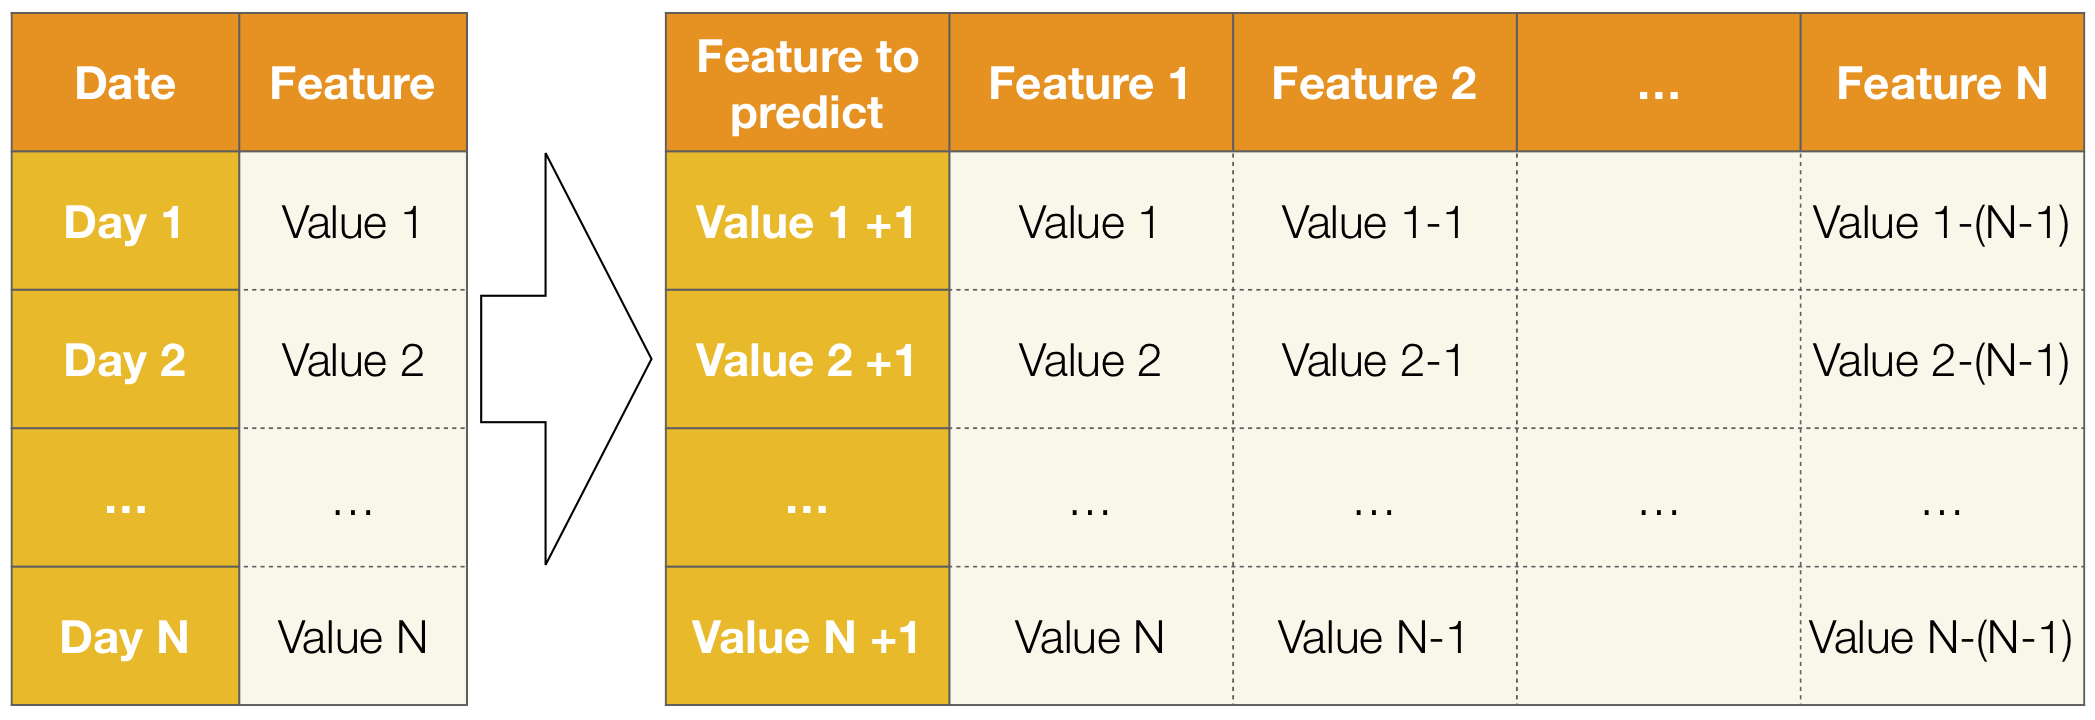

For our specific case we will use the simplest approach where N=1, that is we try to predict the confirmed cases for the day N+1 based on the data from the day N and N-1. This approach as some advantages 
1. Minimises the probability of overtraining the model 
2. Increase the likelihood that the model has to learn some intrinsic data patterns for our problem, e.g. Value N > Value N-1  

We proceed now with the actual implementation. 

In [ ]:
number_of_shifts_input=1

# Same idea as illustrated in this post https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def transpose_the_dataset(dataframe,feature,number_of_shifts=0,print_verbose=False):
    # Gets the full lenght of the dataset 
    if print_verbose:
        print('\n----> Shifting the dataset to convert it into a useful format for a classification problem')
    if number_of_shifts == 0: 
        number_of_shifts = len(dataframe[feature])
    if print_verbose:
        print('Transposing with '+str(number_of_shifts)+' data steps')
        print(dataframe.head())
    for index in range(1,number_of_shifts+1): 
        name_feature_added=feature+'_'+str(index)
        dataframe[name_feature_added]=dataframe[feature].shift(index)
    # The created dataset will have plenty of NaNs, for this specific case associated to days with no registed cases, get rid of them 
    dataframe = dataframe.fillna(0)
    output_df_and_shift = [dataframe,number_of_shifts]
    return output_df_and_shift

In [ ]:
# Arrange the dataset as needed for a classification problem 
df_for_training=transpose_the_dataset(df_for_training,feature_to_analyse,number_of_shifts_input)
# Get the number of shifts and the actual output dataframe 
number_of_shifts = df_for_training[1]
df_for_training = df_for_training[0]

# The created dataset will have plenty of NaNs, for this specific case associated to days with no registed cases, get rid of them 
df_for_training = df_for_training.fillna(0)

# Remove data we don't want to feed into the training 
features_to_drop=['Date', 'Country_Region', 'Fatalities']
for feature_to_drop in features_to_drop:
    df_for_training = df_for_training.drop(feature_to_drop,1)
y_train = df_for_training.pop(feature_to_analyse)
    
print('\nTraining dataset after arrangements needed to convert into a classification problem and cleanup')
print(df_for_training.head())

As expected our training set consists of a single column. 

### **Training the model**

Now it is time to train our BayesianRidge model. The current setup is not necessarily the best. For example we don't optimise the model and we don't make any educated (based on expected data behaviour) guess of the best possible hyperparameter setting for the model. 

In [ ]:
# For saving the model
def save_model(name,model):
  pickle.dump(model, open(name, 'wb'))

# Define and train the model, return the score
def train_model(X_train,y_train,output_modelname,print_verbose=False):
    if print_verbose:
        print("\n----> Training a Bayesian Ridge model")
    bayesian_model = linear_model.BayesianRidge()
    bayesian_model.fit(X_train,y_train)
    score_predictions_train = bayesian_model.predict(X_train)
    if print_verbose: 
        print('Print score_predictions_train')
        print(score_predictions_train)
    save_model(output_modelname+'.pkl',bayesian_model)
    return score_predictions_train

# Train the model and return the predictions for the training dataset
scores = train_model(df_for_training,y_train,'model')

Let's now check how well the model is fitting the training data. 

In [ ]:
# Append the scores to the training data, eventually need to clean this up as not all is necessary..
dataframe_with_scores = pd.DataFrame(data = scores, columns = ['score_predictions_bayes'], index = df_for_training_copy.index.copy())
output_dataframe = pd.merge(df_for_training_copy, dataframe_with_scores, how = 'left', left_index = True, right_index = True)
print('\nPriting training data merged with the model predictions (output_dataframe)')
print(output_dataframe.head())

The snapshot above shows that our model is underfitting in a severe way at least part of the dataset. This is evident by comparing 'score_predictions_bayes' (model score) with 'ConfirmedCases' (feature to predict). We will see in a moment how the model fits the full training dataset and if this property we just highlighted is invalidating our approach.

### **Fitted model vs training data**

We now look into the full training dataset and check if the model is able to fit it. 

In [ ]:
# Prepare some validation plots for the model predictions on trained data
def plot_model_predictions_vs_time(dataframe,base_feature,model_prediction,base_feature_title,print_verbose=False): 
    if print_verbose:
        print('\n----> Plotting model prediction vs time')
    x_len=len(dataframe[base_feature].to_numpy())*0.19
    dataframe['Data-Over-Predicted']=dataframe[base_feature]/dataframe[model_prediction]
    figure(figsize=(x_len, 4.8))
    ax=plt.axes()
    plt.plot(dataframe['Date'], dataframe[base_feature], marker='', linewidth=1, alpha=0.9, label=base_feature_title)
    plt.plot(dataframe['Date'], dataframe[model_prediction], marker='', linewidth=1, alpha=0.9, label='Predicted')
    plt.legend()
    plt.title(base_feature_title+' compared to model predictions')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plot_name=country+'_pred_vs_time.png'
    plt.savefig(plot_name)
    plt.close()
    # Ratio data over predicted 
    dataframe.plot(x="Date", y='Data-Over-Predicted', kind="line",figsize=(x_len,4.8),marker='o')
    plt.title(base_feature_title+' data over predicted '+country)
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plot_name=country+'_data_over_predicted.png'
    plt.savefig(plot_name)
    plt.show()
    plt.close()

#  Prepare some validation plots for the model predictions on trained data (2D plots)
def plot_data_vs_predicted(dataframe,base_feature,model_prediction,base_feature_title,print_verbose=False): 
    if print_verbose:
        print('\n----> Plotting data vs prediction')
    plt.plot(dataframe[base_feature], dataframe[model_prediction], marker='', linewidth=1, alpha=0.9, label=base_feature_title,)
    plt.grid(True)
    plt.title(base_feature_title+' compared to model predictions')
    plt.xlabel('Data')
    plt.ylabel('Predicted')
    plt.tight_layout()
    plot_name=country+'_data_vs_pred.png'
    plt.savefig(plot_name)
    plt.show()
    plt.close()

# Perform some plots
plot_model_predictions_vs_time(output_dataframe,feature_to_analyse,'score_predictions_bayes','Confirmed cases')
plot_data_vs_predicted(output_dataframe,feature_to_analyse,'score_predictions_bayes','Confirmed cases')

### **Discussion of data vs fitted model**

Above you can see two example of plots showing how well the model is able to fit the data, here some considerations 
1. The first plot shows the ratio of the data over the score of the fitted model. Note that all the data shown in this plot is used to train the model. You can see that the model severely over-predicts the number of cases before mid March. This can be caused by lack of flexibility of the fit model and/or severe under-reporting of cases in the initial COVID-19 outbreak whch is not consistent with the overall grow rate of the COVID-19 cases. 
2. The second plot shows overall the linearity response of the fitted model as the number of cases increases. 

### **Make predictions**

Now it is time to make some predictions on the testing set. Here we follow two sequential steps 
1. Apply scores on testing set that overlaps with the training set
2. Apply scores on the non-overlapping days between training and testing sets

In [ ]:
# Add score on days which overalp in training and testing dataset
def add_score_on_overlapping_days(dataframe_base,dataframe_test,print_verbose=False):
    if print_verbose:
        print('\n----> Add prediction on overlapping testing/training datasets')
    dataframe_merged = pd.merge(dataframe_base,dataframe_test,on='Date',how='left')
    # Ensure to keep only the intersection of the two sets by forcing the ID of the second to be not a Nan
    dataframe_merged=dataframe_merged[dataframe_merged.ForecastId==dataframe_merged.ForecastId]
    return dataframe_merged

print('\nNow looking at the dataset for testing for the first time (df_for_testing)')
print(df_for_testing.head())
dataframe_merged =  add_score_on_overlapping_days(df_for_testing,output_dataframe)

# Basic cleanup operations on the testing dataframe which has been merged with the training set
features_to_drop=[feature_to_analyse, 'Data-Over-Predicted', 'Date', 'Country_Region_x', 'Country_Region_y', 'Fatalities', 'ForecastId', 'Province_State']
for feature_to_drop in features_to_drop:
    dataframe_merged = dataframe_merged.drop(feature_to_drop,1)

print('\nPrint dataframe_merged (testing with scores appened) after cleanup')
print(dataframe_merged.head())

### **Comments and further steps**

The test set 'dataframe_merged' incorporates data from the testing set and the model 'predictions' for the days overlapping with the training set. The predictions for the remaining days will have to be filled up based the data available from the previous days. This is done with an iterative procedure as shown below. For each iteration the following operations take place
1. We split the dataset into two components; one, say ds1, with scores (predictions) available, the other, say ds2, without predictions.
2. We extract the row in the dataset which is in order the first to not have a prediction.
3. We apply the model on the row obtained in step 2. 
4. Finally we define a new dataset which glues ds1 with ds2 which now has its first row modified to include the model prediction, with this new dataset we go back to step 1. 

In [ ]:
# Split dataframe into two parts, one which has already the score saved (first), the other which doesn't (second)
dataframe_merged_first = dataframe_merged[dataframe_merged['score_predictions_bayes'] == dataframe_merged['score_predictions_bayes']]
dataframe_merged_second = dataframe_merged[dataframe_merged['score_predictions_bayes'] != dataframe_merged['score_predictions_bayes']]
    
# To be updated in the while loop below
dataframe_concatenated = pd.concat([dataframe_merged_first,dataframe_merged_second])

# Obtain the first row in the testing dataset which has no prediction from the trained model, this is to be used to evaluate the model
# Expected output structure [ConfirmedCases_1,..ConfirmedCases_75]
# This will aslo use the last row with available prediction where the score will be used for the last available data entry ('_1' feature)
def extract_last_row_for_testing(dataframe,number_of_shifts,print_verbose=False,feature=feature_to_analyse): 
    if print_verbose: 
        print('Extract first emtpy row from testing data to be filled up with model prediction')
        print('In extract_last_row_for_testing printing input data')
        print(dataframe.head())
    # Extract first row without a prediction
    row_to_predict = dataframe[dataframe.score_predictions_bayes != dataframe.score_predictions_bayes].head(1)
    # Extract last row with a prediction, to be used to fillup the previous based on actual data and model prediction
    row_predicted = dataframe[dataframe.score_predictions_bayes == dataframe.score_predictions_bayes].tail(1)
    row_predicted_copy = row_predicted.copy()
    for index in range(1,number_of_shifts+1): 
        index_shifted = index-1 
        feature_original=feature+'_'+str(index_shifted)
        feature_mod=feature+'_'+str(index)
        if index == 1: 
            row_predicted[feature+'_1'].iloc[0]=row_predicted_copy['score_predictions_bayes'].iloc[0]
        else: 
            row_predicted[feature_mod].iloc[0]=row_predicted_copy[feature_original].iloc[0]
    if print_verbose:
        print('Original data with prediction')
        print(row_predicted_copy.head())
    # More output cleanup
    features_to_drop_output=['score_predictions_bayes']
    for feature_to_drop_output in features_to_drop_output:
        row_predicted = row_predicted.drop(feature_to_drop_output,1)
    if print_verbose:
        print('Manipulated data to be predicted')
        print(row_predicted.head())
    return row_predicted

def load_and_apply_the_model(dataframe,model_name,print_verbose=False):
    if print_verbose: 
        print('\n----> Loading and applying the model')
    loaded_model = pickle.load(open(model_name+'.pkl', 'rb'))
    score_prediction = loaded_model.predict(dataframe)
    if print_verbose:
        print('Predicted score '+str(score_prediction))
    return score_prediction

def replace_first_row(dataframe_bottom,row,print_verbose=False): 
    if print_verbose:
        print('\n----> Replacing now the first row of the final testing dataset')
        print(dataframe_bottom.head())
        print(row.head())
    row_array = row.to_numpy()
    dataframe_bottom.iloc[0]=row_array.squeeze()
    if print_verbose:
        print('After conversion')
        print(dataframe_bottom.head())
    return dataframe_bottom


# Look to fill up the scores for the second dataframe andeventually attach it back to the first
index = 0
while dataframe_merged_second.score_predictions_bayes.size !=  1: 

    print('\nRemaining days to predict '+str(dataframe_merged_second.score_predictions_bayes.size))
    index = index+1
    if index ==1:
        dataframe_to_be_evaluated = extract_last_row_for_testing(dataframe_merged,number_of_shifts)
    else: 
        #print(dataframe_merged_second.head())
        dataframe_to_be_evaluated = extract_last_row_for_testing(dataframe_merged_second,number_of_shifts)

    # Redefine second dataset taking out the entries with score already filled up
    dataframe_merged_second=dataframe_merged_second[dataframe_merged_second['score_predictions_bayes'] != dataframe_merged_second['score_predictions_bayes']]
    score_to_be_saved = load_and_apply_the_model(dataframe_to_be_evaluated,'logreg')
    dataframe_to_be_evaluated['score_predictions_bayes']=score_to_be_saved

    dataframe_merged_second = replace_first_row(dataframe_merged_second,dataframe_to_be_evaluated)
        
    # Glue the data 
    dataframe_concatenated = pd.concat([dataframe_concatenated,dataframe_merged_second])

### **Final steps**

The final step is to incorporate the results from the previous section into the test dataset. Let's do it and have a quick look at the results. 

In [ ]:
def add_feature(dataframe_base,series,title,print_verbose=False,feature=feature_to_analyse): 
    array=series.to_numpy()
    dataframe_base[feature]=array
    if print_verbose:
        print(array)
        print(dataframe_base.head())
    return dataframe_base

# Now cleanup the dataframe with the predictions (remove nans)
dataframe_concatenated=dataframe_concatenated[dataframe_concatenated.score_predictions_bayes == dataframe_concatenated.score_predictions_bayes]
print(dataframe_concatenated.head())
df_for_testing_copy = df_for_testing.copy()
print(df_for_testing_copy.head())

# Finally add predictions to the testing dataframe and save it as csv
final_output=add_feature(df_for_testing_copy,dataframe_concatenated.score_predictions_bayes,'test') 
print(final_output.head(100))

title_output='testing_confirmed_cases_'+country+'.csv'
final_output.to_csv(title_output, index=False) 

### **Comments**

We inspect now our results (incorporated in 'final_output').  
1. In this simple scenario the model seem to be able to predict growing cumulative COVID-19 cases vs time
2. How does the model prediction compare to the actual data? I am publishing this notebook on 08/05. The model prediction for today is approx 224349 cases to be compared to the actual cases 215858 as reported here https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases. The model is pretty accurate (~95% accuracy) but it is also tuned on a training data which has a strong overlap with the test data.  
3. As expected, according to the discussion in the introduction section, the model tend to over-predict the amount of cases due to the weight of the data from early stage of the pandemic. 